# Proximal Policy Optimization (PPO) BASELINE
---

In [1]:
import gymnasium
import stable_baselines3
from stable_baselines3 import PPO, SAC, TD3, DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.vec_env import VecVideoRecorder

import os
import torch
import numpy
import scipy
import platform
import IPython
import matplotlib
import matplotlib.pyplot
from importlib.metadata import version

In [2]:
ENV = "CartPole-v0" #[Cartpole, MountainCar, MountainCarContinuous, Acrobot, Pendulum]
ALGORITHM = PPO #[PPO, SAC, TD3, DQN]
ALGO_NAME = 'ppo'

In [3]:
def get_steps_and_eval_freq(ENV):
    if "CartPole" in ENV :
        #Max reward per episode: 500
        #Episode ends if:
        #Pole angle > 12°
        #Cart position > 2.4 (off the screen)
        #Or 500 timesteps passed
        #0–50	❌ Agent fails very early
        #100–200	🟡 Learning something
        #>300	🟢 Strong policy
        #500	🏆 Perfect — solved the task
        # 30k is enough for ppo
        
        TOTAL_TIMESTEPS = 30000
        EVAL_FREQUENCY = 1500
        
    elif "MountainCar" in ENV: # FOR PPO AND DQN
        #-200.00: Agent fails every episode
        #-130.00: Agent solves it in ~70 steps (good)
        #-110.00: Agent performs very well

        TOTAL_TIMESTEPS = 200_000
        EVAL_FREQUENCY = 10_000
    elif "MountainCarContinuous" in ENV:  # FOR SAC
        ### NEEDS 300k-1M steps 
        #Reward	Meaning
        #~0	🚫 Agent fails, takes timid or random actions
        #-5 to -1	🚫 Fails, wastes energy (more action → more penalty)
        #50–100	✅ Agent reaches the goal, uses good control
        #~100	🎯 Solved perfectly and efficiently
        
        
        TOTAL_TIMESTEPS = 100000
        EVAL_FREQUENCY = 5000
    elif "Acrobot" in ENV:
        #It's a 2-link pendulum system.
        #The goal is to swing the end of the lower link above a certain height (essentially swing up).
        #The agent applies torque at the joint between the links (discrete action space: [-1, 0, +1]).
        #Episode ends if:
        #The tip of the pendulum reaches a height ≥ 1.0 (i.e., swings up successfully)
        #Or after 500 timesteps (max episode length)
        
        #-500	❌ Agent failed (lasted full 500 steps, never solved)
        #-150 to -400	🟡 Improving, but still inefficient
        #-100 to -200	🟢 Agent swings up relatively quickly
        #-50 to -100	🔥 Excellent — solves early in the episode

        #PPO	200,000 – 500,000
        #DQN	500,000+ (tougher for DQN due to sparse reward)
        
        TOTAL_TIMESTEPS = 10000
        EVAL_FREQUENCY = 1000
    elif "Pendulum" in ENV:
        #-200	❌ Worst case (Agent doesn’t learn or takes no action)
        #-150 to -100	🟡 Learning but not yet great
        #-50 to -100	🟢 Good performance, agent controls pendulum well
        #-10 to -50	🔥 Excellent — near optimal control
        #0 or above	🌟 Perfect — solves task optimally

        #PPO	200,000 – 500,000
        #SAC	100,000 – 300,000
        #TD3	200,000 – 500,000

        TOTAL_TIMESTEPS = 20000
        EVAL_FREQUENCY = 5000
    return TOTAL_TIMESTEPS, EVAL_FREQUENCY
log_dir = f"./logs/{ALGO_NAME}/{ENV}/"


In [4]:
ENVS = ["CartPole", "Acrobot-v1"]#, "MountainCar-v0", "MountainCarContinuous-v0", "Acrobot-v1", "Pendulum" ]

/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/envs/registration.py:527: UserWarning: WARN: Using the latest versioned environment `CartPole-v1` instead of the unversioned environment `CartPole`.
  logger.warn(


Output()

Eval num_timesteps=1500, episode_reward=191.05 +/- 106.73

Episode length: 191.05 +/- 106.73

New best mean reward!

Eval num_timesteps=3000, episode_reward=248.20 +/- 164.15

Episode length: 248.20 +/- 164.15

New best mean reward!

Eval num_timesteps=4500, episode_reward=351.20 +/- 182.81

Eval num_timesteps=6000, episode_reward=347.70 +/- 177.28

Episode length: 347.70 +/- 177.28

Eval num_timesteps=7500, episode_reward=378.55 +/- 135.11

Episode length: 378.55 +/- 135.11

New best mean reward!

Eval num_timesteps=9000, episode_reward=415.85 +/- 104.91

Episode length: 415.85 +/- 104.91

New best mean reward!

Eval num_timesteps=10500, episode_reward=392.00 +/- 107.92

Episode length: 392.00 +/- 107.92

Eval num_timesteps=12000, episode_reward=446.55 +/- 85.32

Episode length: 446.55 +/- 85.32

New best mean reward!

Eval num_timesteps=13500, episode_reward=202.45 +/- 22.33

Episode length: 202.45 +/- 22.33

Eval num_timesteps=15000, episode_reward=463.85 +/- 63.95

Episode length: 463.85 +/- 63.95

New best mean reward!

Eval num_timesteps=16500, episode_reward=479.40 +/- 42.07

Episode length: 479.40 +/- 42.07

New best mean reward!

Eval num_timesteps=18000, episode_reward=463.50 +/- 46.68

Episode length: 463.50 +/- 46.68

Eval num_timesteps=19500, episode_reward=498.75 +/- 5.01

Episode length: 498.75 +/- 5.01

New best mean reward!

Eval num_timesteps=21000, episode_reward=476.00 +/- 48.12

Episode length: 476.00 +/- 48.12

Eval num_timesteps=22500, episode_reward=463.50 +/- 53.75

Episode length: 463.50 +/- 53.75

Eval num_timesteps=24000, episode_reward=500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

New best mean reward!

Eval num_timesteps=25500, episode_reward=474.85 +/- 46.29

Episode length: 474.85 +/- 46.29

Eval num_timesteps=27000, episode_reward=500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

Eval num_timesteps=28500, episode_reward=500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

/opt/homebrew/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 500.00 +/- 0.00


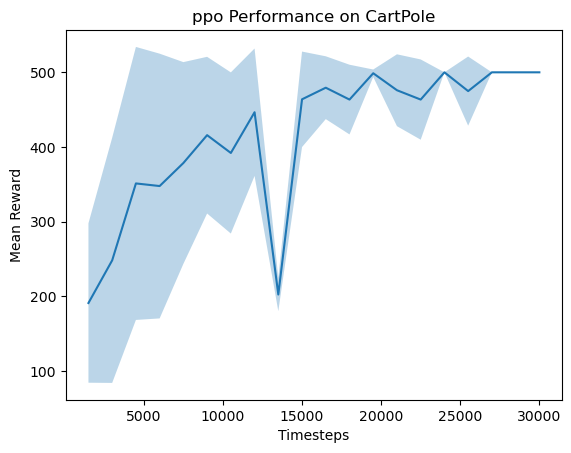

/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/envs/registration.py:527: UserWarning: WARN: Using the latest versioned environment `CartPole-v1` instead of the unversioned environment `CartPole`.
  logger.warn(


Best Model - Mean reward: 500.00 +/- 0.00
MoviePy - Building video /Users/lucamouchel/epfl/Reinforcement learning/project/Deep_RL/baselines/videos/best_model_ppo_CartPole-step-0-to-step-30000.mp4.
MoviePy - Writing video /Users/lucamouchel/epfl/Reinforcement learning/project/Deep_RL/baselines/videos/best_model_ppo_CartPole-step-0-to-step-30000.mp4



Output()

MoviePy - Done !
MoviePy - video ready /Users/lucamouchel/epfl/Reinforcement learning/project/Deep_RL/baselines/videos/best_model_ppo_CartPole-step-0-to-step-30000.mp4


Eval num_timesteps=1000, episode_reward=-500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

New best mean reward!

Eval num_timesteps=2000, episode_reward=-500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

Eval num_timesteps=3000, episode_reward=-389.35 +/- 162.89

Episode length: 389.70 +/- 162.45

New best mean reward!

Eval num_timesteps=4000, episode_reward=-358.00 +/- 152.86

Episode length: 358.50 +/- 152.40

New best mean reward!

Eval num_timesteps=5000, episode_reward=-500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

Eval num_timesteps=6000, episode_reward=-500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

Eval num_timesteps=7000, episode_reward=-500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

Eval num_timesteps=8000, episode_reward=-500.00 +/- 0.00

Episode length: 500.00 +/- 0.00

Eval num_timesteps=9000, episode_reward=-164.75 +/- 106.77

Episode length: 165.70 +/- 106.62

New best mean reward!

Eval num_timesteps=10000, episode_reward=-151.30 +/- 88.66

Episode length: 152.25 +/- 88.47

New best mean reward!

/opt/homebrew/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: -218.10 +/- 175.72


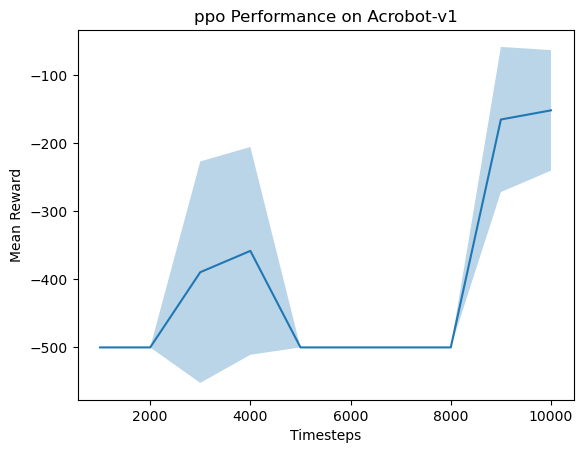

Best Model - Mean reward: -154.12 +/- 73.34
MoviePy - Building video /Users/lucamouchel/epfl/Reinforcement learning/project/Deep_RL/baselines/videos/best_model_ppo_Acrobot-v1-step-0-to-step-10000.mp4.
MoviePy - Writing video /Users/lucamouchel/epfl/Reinforcement learning/project/Deep_RL/baselines/videos/best_model_ppo_Acrobot-v1-step-0-to-step-10000.mp4



MoviePy - Done !
MoviePy - video ready /Users/lucamouchel/epfl/Reinforcement learning/project/Deep_RL/baselines/videos/best_model_ppo_Acrobot-v1-step-0-to-step-10000.mp4


In [5]:
for ENV in ENVS:
    #Create Training Environment
    TOTAL_TIMESTEPS, EVAL_FREQUENCY = get_steps_and_eval_freq(ENV)
    env = gymnasium.make(ENV)
    
    
    #Create Elevation Environment
    env_val = make_vec_env(ENV, n_envs=1)

    eval_callback = EvalCallback(env_val,
                                best_model_save_path=log_dir,
                                log_path=log_dir,
                                eval_freq=EVAL_FREQUENCY,
                                render=False,
                                deterministic=True,
                                n_eval_episodes=20,)


    model = ALGORITHM('MlpPolicy', env, verbose=0, ent_coef=0.05)

    # Train the model
    model.learn(total_timesteps=TOTAL_TIMESTEPS,
                progress_bar=True,
                callback=eval_callback, 
                log_interval=3)

    # Save the model
    model.save(os.path.join(log_dir, f"_{ALGO_NAME}_{ENV}"))

    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=30)
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

    env.close()
    env_val.close()

    # Load the evaluations.npz file
    data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

    # Extract the relevant data
    timesteps = data['timesteps']
    results = data['results']

    # Calculate the mean and standard deviation of the results
    mean_results = numpy.mean(results, axis=1)
    std_results = numpy.std(results, axis=1)

    # Plot the results
    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(timesteps, mean_results)
    matplotlib.pyplot.fill_between(timesteps,
                                mean_results - std_results,
                                mean_results + std_results,
                                alpha=0.3)

    matplotlib.pyplot.xlabel('Timesteps')
    matplotlib.pyplot.ylabel('Mean Reward')
    matplotlib.pyplot.title(f"{ALGO_NAME} Performance on {ENV}")
    matplotlib.pyplot.show()
    
    # Create Elevation environment

    env = make_vec_env(ENV, n_envs=1, seed=0)

    # Load the best model
    best_model_path = os.path.join(log_dir, "best_model.zip")
    best_model = ALGORITHM.load(best_model_path, env=env)

    mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=50)
    print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

    # Record video of the best model playing Lunar Lander
    env = VecVideoRecorder(env, "./videos/",
                        video_length=TOTAL_TIMESTEPS,
                        record_video_trigger=lambda x: x == 0,
                        name_prefix=f"best_model_{ALGO_NAME}_{ENV}")

    obs = env.reset()
    for _ in range(10000):
        action, _states = best_model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()
        if dones:        
            break

    env.close()